In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer



class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def fit_transform(self, X, y=None, sample_weight=None):
        self.fit(X, y, sample_weight)
        return self.transform(X)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [2]:
from pathlib import Path
import os
import sqlite3
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    print("[1] Checking for housing.tgz…")
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        print("[1a] File not found. Creating datasets/ and downloading dataset…")
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        print("[1b] Download completed.")

    print("[2] Extracting housing.tgz…")
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    print("[3] Loading housing.csv into DataFrame…")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

def build_3nf_sqlite(db_path="housing.db"):
    print("=== BUILDING 3NF SQLITE DATA MODEL ===")

    print("\n[STEP 1] Loading CSV into DataFrame…")
    housing = load_housing_data()
    print(f"Loaded {len(housing)} rows.")

    print("\n[STEP 2] Creating surrogate key block_id…")
    housing = housing.reset_index().rename(columns={"index": "block_id"})
    print("block_id added.")

    print("\n[STEP 3] Building ocean_proximity dimension table…")
    ocean_dim = (
        housing[["ocean_proximity"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    ocean_dim["ocean_proximity_id"] = ocean_dim.index + 1
    print(f"Found {len(ocean_dim)} unique ocean_proximity values.")

    print("\n[STEP 4] Merging ocean_proximity_id into main DataFrame…")
    housing = housing.merge(ocean_dim, on="ocean_proximity", how="left")

    print("\n[STEP 5] Creating 3NF DataFrames (ocean, block, stats)…")
    df_ocean = ocean_dim.rename(columns={"ocean_proximity": "name"})[
        ["ocean_proximity_id", "name"]
    ]
    df_block = housing[
        ["block_id", "longitude", "latitude", "ocean_proximity_id"]
    ].drop_duplicates(subset=["block_id"])
    df_stats = housing[
        [
            "block_id",
            "housing_median_age",
            "total_rooms",
            "total_bedrooms",
            "population",
            "households",
            "median_income",
            "median_house_value",
        ]
    ]
    print("3NF DataFrames created.")

    print("\n[STEP 6] Creating SQLite database and tables…")
    if os.path.exists(db_path):
        print("Existing DB found. Removing…")
        os.remove(db_path)

    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    print("Running SQL schema creation script…")
    cur.executescript(
        """
        DROP TABLE IF EXISTS block_housing_stats;
        DROP TABLE IF EXISTS block;
        DROP TABLE IF EXISTS ocean_proximity;

        CREATE TABLE ocean_proximity (
            ocean_proximity_id  INTEGER PRIMARY KEY,
            name                TEXT NOT NULL UNIQUE
        );

        CREATE TABLE block (
            block_id           INTEGER PRIMARY KEY,
            longitude          REAL NOT NULL,
            latitude           REAL NOT NULL,
            ocean_proximity_id INTEGER NOT NULL,
            FOREIGN KEY (ocean_proximity_id)
                REFERENCES ocean_proximity(ocean_proximity_id)
        );

        CREATE TABLE block_housing_stats (
            block_id            INTEGER PRIMARY KEY,
            housing_median_age  REAL NOT NULL,
            total_rooms         INTEGER NOT NULL,
            total_bedrooms      INTEGER,
            population          INTEGER NOT NULL,
            households          INTEGER NOT NULL,
            median_income       REAL NOT NULL,
            median_house_value  REAL NOT NULL,
            FOREIGN KEY (block_id)
                REFERENCES block(block_id)
        );
        """
    )
    print("Tables created.")

    print("\n[STEP 7] Inserting data into SQLite database…")
    print("Inserting ocean_proximity dimension…")
    cur.executemany(
        "INSERT INTO ocean_proximity (ocean_proximity_id, name) VALUES (?, ?)",
        list(df_ocean.itertuples(index=False, name=None)),
    )

    print("Inserting block table…")
    cur.executemany(
        """
        INSERT INTO block (block_id, longitude, latitude, ocean_proximity_id)
        VALUES (?, ?, ?, ?)
        """,
        list(df_block.itertuples(index=False, name=None)),
    )

    print("Inserting block_housing_stats…")
    cur.executemany(
        """
        INSERT INTO block_housing_stats (
            block_id,
            housing_median_age,
            total_rooms,
            total_bedrooms,
            population,
            households,
            median_income,
            median_house_value
        )
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """,
        list(df_stats.itertuples(index=False, name=None)),
    )

    conn.commit()
    conn.close()

    print("\n=== DONE! SQLite DB created at:", db_path, "===\n")


build_3nf_sqlite("housing.db")


=== BUILDING 3NF SQLITE DATA MODEL ===

[STEP 1] Loading CSV into DataFrame…
[1] Checking for housing.tgz…
[2] Extracting housing.tgz…
[3] Loading housing.csv into DataFrame…
Loaded 20640 rows.

[STEP 2] Creating surrogate key block_id…


/tmp/ipython-input-1429435954.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


block_id added.

[STEP 3] Building ocean_proximity dimension table…
Found 5 unique ocean_proximity values.

[STEP 4] Merging ocean_proximity_id into main DataFrame…

[STEP 5] Creating 3NF DataFrames (ocean, block, stats)…
3NF DataFrames created.

[STEP 6] Creating SQLite database and tables…
Existing DB found. Removing…
Running SQL schema creation script…
Tables created.

[STEP 7] Inserting data into SQLite database…
Inserting ocean_proximity dimension…
Inserting block table…
Inserting block_housing_stats…

=== DONE! SQLite DB created at: housing.db ===



In [3]:
conn = sqlite3.connect("housing.db")
housing = pd.read_sql_query(
    """
    SELECT
        b.block_id,
        b.longitude,
        b.latitude,
        s.housing_median_age,
        s.total_rooms,
        s.total_bedrooms,
        s.population,
        s.households,
        s.median_income,
        s.median_house_value,
        op.name AS ocean_proximity
    FROM block AS b
    JOIN block_housing_stats AS s
        ON s.block_id = b.block_id
    JOIN ocean_proximity AS op
        ON op.ocean_proximity_id = b.ocean_proximity_id
    ORDER BY b.block_id
    """,
    conn,
)
conn.close()

In [7]:
housing

,block_id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880,129.0,322,126,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND
20636,20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND
20637,20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND
20638,20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND


<Axes: xlabel='income_cat'>

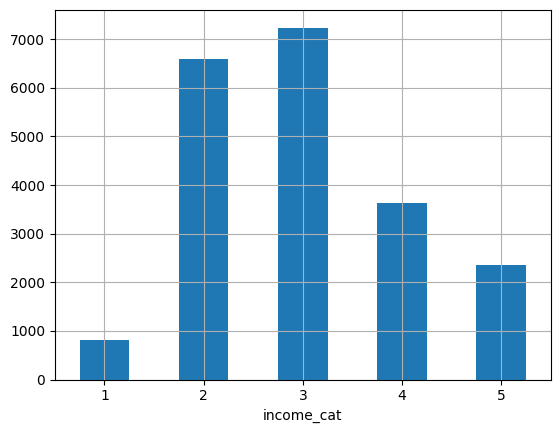

In [4]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)


In [5]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.20, stratify=housing["income_cat"], random_state=42)
strat_train_set["income_cat"].value_counts() / len(strat_train_set)
strat_test_set["income_cat"].value_counts() / len(strat_test_set)
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing = strat_train_set.copy() ### I am re-writing to we don't use the test accidently.
housing_target = strat_train_set["median_house_value"].copy()
housing.drop(["block_id", "median_house_value"], axis=1, inplace=True)

In [6]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [7]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [8]:
df = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out())
df

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,8.708837e-08,9.712456e-01,...,7.114441e-04,3.070969e-17,1.314047e-01,5.740031e-01,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.181328e-01,9.738096e-14,...,3.045359e-27,5.437838e-01,1.735342e-09,2.275194e-10,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.295286e-08,7.457782e-01,...,4.750719e-03,1.605970e-17,2.744847e-01,2.839978e-01,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,4.618947e-04,3.873884e-20,...,2.916178e-35,7.405721e-01,2.243339e-14,4.218649e-16,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,3.166634e-02,7.905346e-16,...,2.843975e-30,7.501278e-01,2.890866e-11,3.710912e-12,0.0,0.0,0.0,0.0,1.0,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,7.592469e-02,1.255430e-14,...,1.004491e-28,5.539064e-01,2.304608e-10,4.272885e-11,1.0,0.0,0.0,0.0,0.0,0.987087
16508,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,1.122830e-01,8.422138e-06,...,4.942583e-14,1.831519e-04,6.702758e-03,4.498431e-04,0.0,1.0,0.0,0.0,0.0,-0.443146
16509,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,6.789654e-06,3.595707e-25,...,7.917098e-43,1.250634e-01,3.348665e-19,2.064542e-20,0.0,0.0,0.0,0.0,1.0,-1.237721
16510,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,1.096450e-01,6.165959e-14,...,1.332778e-27,5.435921e-01,1.066970e-09,1.586255e-10,1.0,0.0,0.0,0.0,0.0,0.669257


In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_target)
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(2)
housing_target.iloc[:5].values

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x789...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x789d2bf80140>)])),
                ('linearregression', LinearRegression())])

array([242761.81, 375862.79, 127480.98,  99355.3 , 324610.74])

array([458300., 483800., 101700.,  96100., 361800.])

In [25]:
error_ratios = housing_predictions[:5].round(2) / housing_target.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


In [11]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_target, housing_predictions)
lin_mae

50899.597369196425

In [12]:
test_housing = strat_test_set.copy()
test_housing_target = strat_test_set["median_house_value"].copy()
test_housing.drop(["block_id", "median_house_value"], axis=1, inplace=True)
test_housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
3905,-121.95,37.11,21.0,2387,357.0,913,341,7.7360,<1H OCEAN
16821,-118.01,33.89,36.0,1589,265.0,804,272,4.6354,<1H OCEAN
2900,-118.18,33.74,30.0,5915,1750.0,2136,1503,4.0968,NEAR OCEAN
7193,-122.48,37.74,52.0,2166,423.0,1072,370,4.1310,NEAR OCEAN
13928,-122.39,37.78,5.0,1405,515.0,725,392,3.6037,NEAR BAY
...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042,597.0,1206,541,2.1135,NEAR OCEAN
8707,-119.01,35.39,29.0,1820,459.0,1134,419,1.8289,INLAND
16634,-123.01,38.67,33.0,914,147.0,394,132,4.6875,<1H OCEAN
9779,-122.03,37.60,24.0,2077,383.0,1488,389,4.5721,NEAR BAY


In [13]:
test_housing_predictions = lin_reg.predict(test_housing)
test_housing_predictions[:5].round(2)
test_housing_target.iloc[:5].values

array([361080.37, 268525.11, 357261.26, 292931.94, 271207.99])

array([397700., 202900., 310000., 314300., 187500.])

In [19]:
lin_reg[1].__class__.__name__

'LinearRegression'

In [14]:
test_lin_mae = mean_absolute_error(test_housing_target, test_housing_predictions)
test_lin_mae

52381.46366731196

In [21]:
import os

MLFLOW_TRACKING_URI="https://dagshub.com/mkzia/housing_fall2025.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']='mkzia'
os.environ['MLFLOW_TRACKING_PASSWORD']='9276e61675a1962b10667ef1b4bb678f49aa977a'


import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Create a new MLflow Experiment
mlflow.set_experiment("median_house_pricing")

score = test_lin_mae
params = lin_reg[1].get_params()
with mlflow.start_run():
      # Log the hyperparameters
      mlflow.log_params(params)

      # Log metrics
      mlflow.log_metric("MAE", score)
      # Infer the model signature
      signature = infer_signature(housing, lin_reg.predict(housing))

      # Log the model
      model_info = mlflow.sklearn.log_model(
          sk_model=lin_reg[1],
          artifact_path="housing_model",
          signature=signature,
          input_example=housing,
          registered_model_name=lin_reg[1].__class__.__name__,
      )

2025/12/05 00:31:30 INFO mlflow.tracking.fluent: Experiment with name 'median_house_pricing' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/127bcd4201b54d48aec4473b96f21c94', creation_time=1764894690198, experiment_id='0', last_update_time=1764894690198, lifecycle_stage='active', name='median_house_pricing', tags={}>

Streaming output truncated to the last 5000 lines.
      [
        -121.18,
        38.73,
        16.0,
        1584,
        264.0,
        613,
        226,
        6.0302,
        "INLAND"
      ],
      [
        -117.23,
        32.8,
        27.0,
        1297,
        355.0,
        776,
        337,
        2.4643,
        "NEAR OCEAN"
      ],
      [
        -122.08,
        37.63,
        34.0,
        1619,
        293.0,
        1148,
        310,
        4.0326,
        "NEAR BAY"
      ],
      [
        -119.02,
        35.33,
        26.0,
        3691,
        826.0,
        2072,
        827,
        2.1553,
        "INLAND"
      ],
      [
        -121.79,
        37.0,
        28.0,
        2715,
        451.0,
        1154,
        386,
        4.8021,
        "<1H OCEAN"
      ],
      [
        -117.88,
        33.84,
        31.0,
        3301,
        712.0,
        1532,
        682,
        3.7303,
        "<1H OCEAN"
      ],
      [
        -118.32,
    

🏃 View run receptive-pig-215 at: https://dagshub.com/mkzia/housing_fall2025.mlflow/#/experiments/0/runs/55294f1d7d7f4be3a480a0c0f1036f55
🧪 View experiment at: https://dagshub.com/mkzia/housing_fall2025.mlflow/#/experiments/0


Created version '1' of model 'LinearRegression'.


In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_target)
housing_predictions = tree_reg.predict(housing)
tree_mae = mean_absolute_error(housing_target, housing_predictions)
tree_mae

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x789...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x789d2bf80140>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

0.0

In [25]:
housing_target[:5].values
housing_predictions[:5]

array([458300., 483800., 101700.,  96100., 361800.])

array([458300., 483800., 101700.,  96100., 361800.])

In [26]:
test_housing = strat_test_set.copy()
test_housing_target = strat_test_set["median_house_value"].copy()
test_housing.drop(["block_id", "median_house_value"], axis=1, inplace=True)
test_housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
3905,-121.95,37.11,21.0,2387,357.0,913,341,7.7360,<1H OCEAN
16821,-118.01,33.89,36.0,1589,265.0,804,272,4.6354,<1H OCEAN
2900,-118.18,33.74,30.0,5915,1750.0,2136,1503,4.0968,NEAR OCEAN
7193,-122.48,37.74,52.0,2166,423.0,1072,370,4.1310,NEAR OCEAN
13928,-122.39,37.78,5.0,1405,515.0,725,392,3.6037,NEAR BAY
...,...,...,...,...,...,...,...,...,...
12369,-124.16,40.79,46.0,3042,597.0,1206,541,2.1135,NEAR OCEAN
8707,-119.01,35.39,29.0,1820,459.0,1134,419,1.8289,INLAND
16634,-123.01,38.67,33.0,914,147.0,394,132,4.6875,<1H OCEAN
9779,-122.03,37.60,24.0,2077,383.0,1488,389,4.5721,NEAR BAY


In [27]:
test_housing_predictions = tree_reg.predict(test_housing)
tree_mae = mean_absolute_error(test_housing_target, test_housing_predictions)
tree_mae

41747.78972868217

In [28]:
tree_reg[1].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [43]:
tree_reg[1].feature_importances_

array([1.93310820e-02, 2.23023303e-02, 1.15224454e-01, 6.08091812e-03,
       1.12964147e-02, 7.63132337e-03, 9.87141786e-03, 4.63070445e-01,
       2.99994205e-02, 1.64673644e-02, 1.80403671e-02, 7.28937817e-03,
       3.19889418e-02, 2.27660950e-02, 6.33527177e-03, 1.28375303e-02,
       9.76197559e-03, 1.83066394e-02, 1.40349468e-03, 1.37184112e-01,
       0.00000000e+00, 8.67582234e-05, 1.15786672e-03, 3.15663997e-02])

In [23]:
tree_reg[1].get_params()

NameError: name 'tree_reg' is not defined

In [46]:
sorted(zip(tree_reg[1].feature_importances_.round(2),
           tree_reg[0].get_feature_names_out()),
           reverse=True)

[(np.float64(0.46), 'log__median_income'),
 (np.float64(0.14), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.12), 'people_per_house__ratio'),
 (np.float64(0.03), 'remainder__housing_median_age'),
 (np.float64(0.03), 'geo__Cluster 4 similarity'),
 (np.float64(0.03), 'geo__Cluster 0 similarity'),
 (np.float64(0.02), 'rooms_per_house__ratio'),
 (np.float64(0.02), 'geo__Cluster 9 similarity'),
 (np.float64(0.02), 'geo__Cluster 5 similarity'),
 (np.float64(0.02), 'geo__Cluster 2 similarity'),
 (np.float64(0.02), 'geo__Cluster 1 similarity'),
 (np.float64(0.02), 'bedrooms__ratio'),
 (np.float64(0.01), 'log__total_rooms'),
 (np.float64(0.01), 'log__total_bedrooms'),
 (np.float64(0.01), 'log__population'),
 (np.float64(0.01), 'log__households'),
 (np.float64(0.01), 'geo__Cluster 8 similarity'),
 (np.float64(0.01), 'geo__Cluster 7 similarity'),
 (np.float64(0.01), 'geo__Cluster 6 similarity'),
 (np.float64(0.01), 'geo__Cluster 3 similarity'),
 (np.float64(0.0), 'cat__ocean_proximity_NEAR OCEAN

In [ ]:
!pip install "mlflow<3"

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

In [29]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}

[I 2025-12-05 00:38:58,152] A new study created in memory with name: no-name-0c982886-aa2e-454b-a76a-2b8308df86b2
[I 2025-12-05 00:38:58,170] Trial 0 finished with value: 70.87988599732488 and parameters: {'x': -6.419019301398761}. Best is trial 0 with value: 70.87988599732488.
[I 2025-12-05 00:38:58,185] Trial 1 finished with value: 1.1546935329300951 and parameters: {'x': 3.0745666721660854}. Best is trial 1 with value: 1.1546935329300951.
[I 2025-12-05 00:38:58,190] Trial 2 finished with value: 94.47045667169363 and parameters: {'x': -7.719591383987994}. Best is trial 1 with value: 1.1546935329300951.
[I 2025-12-05 00:38:58,203] Trial 3 finished with value: 28.38198129262196 and parameters: {'x': 7.327474194458567}. Best is trial 1 with value: 1.1546935329300951.
[I 2025-12-05 00:38:58,211] Trial 4 finished with value: 2.5642686630962563 and parameters: {'x': 0.39866659839487006}. Best is trial 1 with value: 1.1546935329300951.
[I 2025-12-05 00:38:58,223] Trial 5 finished with value

{'x': 2.0013416868263767}

In [30]:
from sklearn.ensemble import RandomForestRegressor

random_forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
random_forest_reg.fit(housing, housing_target)
housing_predictions = random_forest_reg.predict(housing)
random_forest_mae = mean_absolute_error(housing_target, housing_predictions)
random_forest_mae

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x789...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x789d2bf80140>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

11156.659145469961

In [31]:
test_housing_predictions = random_forest_reg.predict(test_housing)
random_forest_mae = mean_absolute_error(test_housing_target, test_housing_predictions)
random_forest_mae

30229.328880813955

In [32]:
random_forest_reg[1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
import optuna
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Your existing pipeline
full_pipeline = random_forest_reg

def objective(trial):
    n_clusters = trial.suggest_categorical(
        "columntransformer__geo__n_clusters",
        [5, 8, 10, 15]   # combine both grids
    )
    max_features = trial.suggest_categorical(
        "randomforestregressor__max_features",
        [4, 6, 8, 10]    # combine both grids
    )

    # clone base pipeline so we don't mutate the original
    model = clone(full_pipeline)
    model.set_params(
        columntransformer__geo__n_clusters=n_clusters,
        randomforestregressor__max_features=max_features,
    )

    # 3-fold CV with the same metric as GridSearchCV
    scores = cross_val_score(
        model,
        housing,
        housing_target,
        cv=3,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )

    # cross_val_score returns NEGATIVE RMSE -> make it positive for Optuna
    mae = -scores.mean()
    return mae  # Optuna will MINIMIZE this

# ---- run Optuna study ----
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, show_progress_bar=True)  # adjust n_trials for class time

print("Best MAE (CV):", study.best_value)
print("Best params:", study.best_params)

# ---- train final model on all data with best params ----
best_pipeline = clone(full_pipeline)
best_pipeline.set_params(**study.best_params)
best_pipeline.fit(housing, housing_target)


[I 2025-12-05 00:49:10,640] A new study created in memory with name: no-name-0095efa5-6721-456c-b11b-3728bae917cd


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-05 00:49:58,908] Trial 0 finished with value: 30804.75138687016 and parameters: {'columntransformer__geo__n_clusters': 5, 'randomforestregressor__max_features': 8}. Best is trial 0 with value: 30804.75138687016.
[I 2025-12-05 00:50:25,464] Trial 1 finished with value: 29004.588329093993 and parameters: {'columntransformer__geo__n_clusters': 8, 'randomforestregressor__max_features': 6}. Best is trial 1 with value: 29004.588329093993.
[I 2025-12-05 00:51:01,021] Trial 2 finished with value: 28344.854097020347 and parameters: {'columntransformer__geo__n_clusters': 15, 'randomforestregressor__max_features': 8}. Best is trial 2 with value: 28344.854097020347.
[I 2025-12-05 00:51:35,200] Trial 3 finished with value: 28344.854097020347 and parameters: {'columntransformer__geo__n_clusters': 15, 'randomforestregressor__max_features': 8}. Best is trial 2 with value: 28344.854097020347.
[I 2025-12-05 00:52:08,675] Trial 4 finished with value: 29501.493402979653 and parameters: {'column

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x789...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x789d1c3b5fd0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=4, random_state=42))])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x789...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x789d1c3b5fd0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=4, random_state=42))])



### Cross-Validation

The data is split into non-overlapping subsets (folds), meaning each data point is used exactly once as part of the validation set and exactly \(k-1\) times as part of the training set during \(k\)-fold cross-validation.

---

### **How Are Data Selected for a Fold?**

#### **Splitting the Data**
- The dataset is divided into \(k\) approximately equal-sized subsets (folds) **without replacement**.
- Each fold contains a unique subset of the data, and no data point is repeated across folds.

In [37]:
from sklearn.model_selection import cross_val_score

random_forest_mae_cv = -cross_val_score(random_forest_reg, housing, housing_target,
                              scoring="neg_mean_absolute_error", cv=3)

# The cross_val_score function returns scores where higher is better.
# For metrics like RMSE (where lower is better), scikit-learn negates the values to fit this convention.

In [38]:
pd.Series(random_forest_mae_cv).describe()

,0
count,3.000000
mean,30868.040237
std,332.127520
min,30540.683585
25%,30699.689650
50%,30858.695716
75%,31031.718564
max,31204.741412


In [49]:
from sklearn.decomposition import PCA
preprocessing_with_pca = Pipeline([
    ("preprocessing", preprocessing),
    ("pca", PCA(n_components=0.95)),
])

In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing_with_pca, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_target)
housing_predictions = tree_reg.predict(housing)
tree_mae = mean_absolute_error(housing_target, housing_predictions)
tree_mae

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                               SimpleImputer(strategy='median')),
                                                                              ('standardscaler',
                                                                               StandardScaler())]),
                                                    transformers=[('bedrooms',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('functiontransformer',
                                                                                    FunctionTransformer(feature_names_out=<f...
                                                                   ['latitude',
                                                                    'longitude']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x789d2bf80140>)])),
                                 ('pca', PCA(n_components=0.95))])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

0.0

In [52]:
tree_reg[1].feature_importances_


array([0.04287567, 0.27553027, 0.08510024, 0.25648795, 0.03218544,
       0.1127817 , 0.09565508, 0.05152554, 0.04785811])

In [53]:
test_housing_predictions = tree_reg.predict(test_housing)
tree_mae = mean_absolute_error(test_housing_target, test_housing_predictions)
tree_mae

54219.3316375969

In [54]:
sorted(zip(tree_reg[1].feature_importances_.round(2),
           tree_reg[0].get_feature_names_out()),
           reverse=True)

[(np.float64(0.28), 'pca1'),
 (np.float64(0.26), 'pca3'),
 (np.float64(0.11), 'pca5'),
 (np.float64(0.1), 'pca6'),
 (np.float64(0.09), 'pca2'),
 (np.float64(0.05), 'pca8'),
 (np.float64(0.05), 'pca7'),
 (np.float64(0.04), 'pca0'),
 (np.float64(0.03), 'pca4')]

In [56]:
tree_reg[1].feature_importances_.sum()

np.float64(0.9999999999999999)

In [ ]:
import pandas as pd
import joblib

# Example: Save model metadata
metadata = {
    'model_name': ['DecisionTreeRegressor'],
    'mae': [54219],
}
df = pd.DataFrame(metadata)
df.to_csv('model_metadata.csv', index=False)

# Save the model
joblib.dump(tree_reg, 'random_forest_model.pkl')